In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
# Module for personal library import
import sys
sys.path.append("../") 
from personal_library.NPL.preprocess import (
    remove_pattern,
    rm_pun_num_esp_cha,
    rm_length_word,
    tokenize,
    stemmer,
    join_tokenize,
    hashtag_extract,
    count_caps,
    hashtag_rm
)

In [35]:
from personal_library.NPL.data_analysis import(
    plot_labels_wordcloud,
    plot_hashtag_hist,
)

In [4]:
# Path to train and test files
train_path = '../data/train_E6oV3lV.csv'
test_path = '../data/test_tweets_anuFYb8.csv'

train  = pd.read_csv(train_path)
test = pd.read_csv(test_path)

all_data = train.append(test, ignore_index=True, sort=True)

train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [44]:
all_data['tidy_tweet'] = np.vectorize(remove_pattern)(all_data['tweet'], "@[\w]*")
all_data['tidy_tweet'] = rm_pun_num_esp_cha(all_data['tidy_tweet'])
all_data['tidy_tweet'] = rm_length_word(all_data['tidy_tweet'])

tokenized_tweet = tokenize(all_data['tidy_tweet'])
tokenized_tweet = stemmer(tokenized_tweet)
all_data['tidy_tweet'] = join_tokenize(tokenized_tweet)
all_data['hashtag'] = hashtag_extract(all_data['tidy_tweet'], flatten=False)
all_data['tidy_tweet'] = np.vectorize(remove_pattern)(all_data['tidy_tweet'], "#[\w]*")

tokenized_tweet = tokenize(all_data['tidy_tweet'])

all_data.head()

,id,label,tweet,tidy_tweet,hashtag
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...,[run]
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank credit caus they offer wheelchair van,"[lyft, disapoint, getthank]"
2,3,0.0,bihday your majesty,bihday your majesti,[]
3,4,0.0,#model i love u take with u all the time in ...,love take with time,[model]
4,5,0.0,factsguide: society now #motivation,factsguid societi,[motiv]


In [39]:
import math
for i in all_data['label'].unique():
    print(not math.isnan(i))
    data = all_data[all_data['label'] == i]['tidy_tweet']
    print(len(data))

True
29720
True
2242
False
0


All data Wordcloud


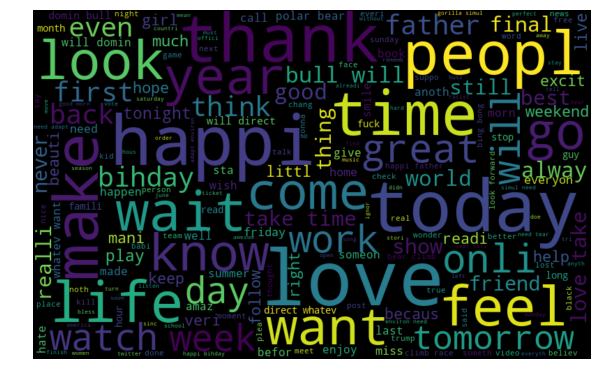

0.0
1.0


In [36]:
plot_labels_wordcloud(all_data,'tidy_tweet', 'label', add_all=True, only_all=False)

In [ ]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(all_data['tidy_tweet'][all_data['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(all_data['tidy_tweet'][all_data['label'] == 1])
print('hashtags from non racist/sexist tweets')
plot_hashtag_hist(HT_regular)

print('hashtags from racist/sexist tweets')
plot_hashtag_hist(HT_negative)

# Clasic Machine Learning

In [11]:
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)

# bag-of-words feature matrix
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(all_data['tidy_tweet'])

# TF-IDF feature matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(all_data['tidy_tweet'])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

# Logistic Regression with BOW
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

print("Logistic Regression with BOW f1: {}".format(f1_score(yvalid, prediction_int)))


# Logistic Regression with TF-IDF
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

print("Logistic Regression with TF-IDF f1: {}".format(f1_score(yvalid, prediction_int)))

Logistic Regression with BOW f1: 0.5373134328358208
Logistic Regression with TF-IDF f1: 0.5542806707855252


In [13]:
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# TF-IDF

"""KNeighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh = neigh.fit(xtrain_tfidf.toarray(), ytrain)
y_pred = neigh.predict(xvalid_tfidf.toarray())
print("KNeighbors with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))
"""

"""Naive Bayes Gaussian"""
gnb = GaussianNB()
gnb = gnb.fit(xtrain_tfidf.toarray(), ytrain)
y_pred = gnb.predict(xvalid_tfidf.toarray())
print("Naive Bayes Gaussian with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))


"""Decision Tree Classifier"""
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xtrain_tfidf, ytrain)  
y_pred = clf.predict(xvalid_tfidf)
print("Decision Tree Classifier with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))


"""SVM"""
svm = LinearSVC()
svm.fit(xtrain_tfidf, ytrain)  

y_pred = svm.predict(xvalid_tfidf)
print("SVM with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))

Naive Bayes Gaussian with TF-IDF f1: 0.22451232977548766
Decision Tree Classifier with TF-IDF f1: 0.5105663567202029
SVM with TF-IDF f1: 0.49218749999999994


In [14]:
# BOW

"""KNeighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh = neigh.fit(xtrain_bow.toarray(), ytrain)
y_pred = neigh.predict(xvalid_bow.toarray())
print("KNeighbors with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))
"""

"""Naive Bayes Gaussian"""
gnb = GaussianNB()
gnb = gnb.fit(xtrain_bow.toarray(), ytrain)
y_pred = gnb.predict(xvalid_bow.toarray())
print("Naive Bayes Gaussian with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))


"""Decision Tree Classifier"""
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xtrain_bow, ytrain)  
y_pred = clf.predict(xvalid_bow)
print("Decision Tree Classifier with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))


"""SVM"""
svm = LinearSVC()
svm.fit(xtrain_bow, ytrain)  

y_pred = svm.predict(xvalid_bow)
print("SVM with TF-IDF f1: {}".format(f1_score(yvalid, y_pred)))

Naive Bayes Gaussian with TF-IDF f1: 0.22026273168976063
Decision Tree Classifier with TF-IDF f1: 0.48235294117647054
SVM with TF-IDF f1: 0.4956437560503388


In [15]:
from scipy.sparse import hstack

# Stack BOW and TF-IDF
x_val = hstack([xvalid_tfidf,xvalid_bow])
x_train = hstack([xtrain_tfidf,xtrain_bow])

"""Logistic Regression"""
lreg = LogisticRegression()
lreg.fit(x_train, ytrain)
prediction = lreg.predict_proba(x_val)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

print("Logistic Regression with TF-IDF and BOW f1: {}".format(f1_score(yvalid, prediction_int)))

"""SVM"""
svm = LinearSVC()
svm.fit(x_train, ytrain)  

y_pred = svm.predict(x_val)
print("SVM with TF-IDF and BOW  f1: {}".format(f1_score(yvalid, y_pred)))


"""Decision Tree Classifier"""
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, ytrain)  
y_pred = clf.predict(x_val)
print("Decision Tree Classifier with TF-IDF and BOW f1: {}".format(f1_score(yvalid, y_pred)))

Logistic Regression with TF-IDF and BOW f1: 0.5438165438165438
SVM with TF-IDF and BOW  f1: 0.509915014164306
Decision Tree Classifier with TF-IDF and BOW f1: 0.5217391304347826


# Neural Networks

In [16]:
from sklearn import decomposition

x_train = x_train.toarray()
x_test = x_val.toarray()
y_train = ytrain
y_test = yvalid

In [17]:
pca = decomposition.PCA(n_components=0.95, svd_solver='full')
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(22373, 812)
(22373,)
(9589, 812)
(9589,)


In [18]:
conteo_mayusculas = count_caps(all_data['tidy_tweet'])

In [19]:
np.count_nonzero(conteo_mayusculas)

0

In [ ]:
from keras import backend as K
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from personal_library.sce_keras.callbacks import (
    F1PrecisionRecall,
    LearningRateDecay
)
from personal_library.sce_keras.loss_functions import f1_loss
from personal_library.sce_keras.metrics_functions import f1


num_classes = 1
batch_size = 32
epochs = 50
learnRate = 0.001

metric = F1PrecisionRecall()
lrate_decay = LearningRateDecay(epochs, learnRate).poly_decay

#Define model architecture
model = Sequential()
model.add( Dense( 2048, activation='relu', input_shape=(x_train.shape[1],) ) )
model.add(BN())
model.add(GN(0.3))
model.add(Activation('relu'))

model.add(Dense(1024))
model.add(BN())
model.add(GN(0.3))
model.add(Activation('relu'))

model.add(Dense(512))
model.add(BN())
model.add(GN(0.3))
model.add(Activation('relu'))

model.add(Dense(256))
model.add(BN())
model.add(GN(0.3))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='sigmoid'))
#model.summary()

checkpoint_path = "../model_wehigts/Wehigts.hdf5"
checkpointer = ModelCheckpoint(filepath=checkpoint_path,
                               monitor='val_loss', verbose=1,
                               save_best_only=True, mode='min')

adam = Adam(lr=learnRate, beta_1=0.9, beta_2=0.999,
            epsilon=None, decay=1e-6, amsgrad=False)
rms = RMSprop(lr=learnRate, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss=f1_loss, 
            optimizer=adam, 
            metrics=['accuracy', f1]) 

history = model.fit(x_train, y_train, 
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[checkpointer, metric, lrate_decay])


In [41]:
#Load best model
model.load_weights(checkpoint_path)
y_pred = model.predict(x_test, batch_size=1)
y_pred = np.where(y_pred > 0.5, 1, 0)

print("Neural Network f1_sklearn: {}".format(f1_score(y_test, y_pred)))

Neural Network f1_sklearn: 0.5552742616033756


# WORD2VEC

In [40]:
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE

In [41]:
en_model = KeyedVectors.load_word2vec_format('../data/vectors/cc.en.300.vec')

In [ ]:
from personal_library.NPL.core.model_preprocessors import corpus2vec

test = corpus2vec(en_model, tokenized_tweet, use_next=True)
np.savetxt('vectorize_data.txt', test)
test.shape

In [ ]:
np.savetxt('vectorize_data.txt', test)
test.shape

# COMPLEX MODEL

In [ ]:
inp = Input(shape = (max_len,))
x = Embedding(nb_words+1, embed_size, weights = [embedding_matrix], trainable=False)(inp)
x1 = SpatialDropout1D(spatial_dr)(x)

x_gru = Bidirectional(GRU(units, return_sequences=True))(x1)
x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool1_gru = GlobalAveragePooling1D()(x1)
max_pool1_gru = GlobalMaxPooling1D()(x1)

x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool3_gru = GlobalAveragePooling1D()(x3)
max_pool3_gru = GlobalMaxPooling1D()(x3)

x_lstm = Bidirectional(LSTM(units, return_sequences=True))(x1)
x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool1_lstm = GlobalAveragePooling1D()(x1)
max_pool1_lstm = GlobalMaxPooling1D()(x1)

x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool3_lstm = GlobalAveragePooling1D()(x3)
max_pool3_lstm = GlobalMaxPooling1D()(x3)


x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
x = BatchNormalization()(x)
x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
x = BatchNormalization()(x)
x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
x = Dense(1, activation = "sigmoid")(x)